# Encoding categorical features

This section explains the way categorical encoding can be carried out using `feature_encoders`.

All encoders take `pandas.DataFrame`s as input and generate `numpy.ndarray`s as output.

In [1]:
import matplotlib.cm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.model_selection import KFold
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

%matplotlib inline

In [2]:
from feature_encoders.encode import (
    SafeOrdinalEncoder, 
    SafeOneHotEncoder, 
    TargetClusterEncoder, 
    CategoricalEncoder
)

A plotting utility:

In [3]:
def get_colors(cmap, N=None, use_index="auto"):
    if isinstance(cmap, str):
        if use_index == "auto":
            if cmap in ['Pastel1', 'Pastel2', 'Paired', 'Accent',
                        'Dark2', 'Set1', 'Set2', 'Set3',
                        'tab10', 'tab20', 'tab20b', 'tab20c']:
                use_index=True
            else:
                use_index=False
        cmap = matplotlib.cm.get_cmap(cmap)
    if not N:
        N = cmap.N
    if use_index=="auto":
        if cmap.N > 100:
            use_index=False
        elif isinstance(cmap, LinearSegmentedColormap):
            use_index=False
        elif isinstance(cmap, ListedColormap):
            use_index=True
    if use_index:
        ind = np.arange(int(N)) % cmap.N
        return cmap(ind)
    else:
        return cmap(np.linspace(0,1,N))

## Load demo data

The demo data represents the energy consumption of a building.

In [4]:
data = pd.read_csv('data/data.csv', parse_dates=[0], index_col=0)
data = data[~data['consumption_outlier']]
data.dtypes

consumption            float64
holiday                 object
temperature            float64
consumption_outlier       bool
dtype: object

`holiday` is a categorical feature. The `_novalue_` value corresponds to non-holiday observations.

In [5]:
data['holiday'].value_counts()

_novalue_                       35943
Immaculate Conception             192
Christmas Day                     192
St Stephen's Day                  192
New year                           96
Epiphany                           96
Easter Monday                      96
Liberation Day                     96
International Workers' Day         96
Republic Day                       96
Assumption of Mary to Heaven       96
All Saints Day                     96
Name: holiday, dtype: int64

## `SafeOrdinalEncoder`


The `SafeOrdinalEncoder` converts categorical features into ordinal integers. This results
in a single column of integers (0 to n_categories - 1) per feature. Unknown categories will be replaced using the most frequent value along each column.

It is implemented as a pipeline:

```python
UNKNOWN_VALUE = -1

Pipeline(
    [
        (
            "select",
            sklearn.compose.ColumnTransformer(
                [("select", "passthrough", self.features_)], remainder="drop"
            ),
        ),
        (
            "encode_ordinal",
            sklearn.preprocessing.OrdinalEncoder(
                handle_unknown="use_encoded_value",
                unknown_value=self.unknown_value or UNKNOWN_VALUE,
                dtype=np.int16,
            ),
        ),
        (
            "impute_unknown",
            sklearn.impute.SimpleImputer(
                missing_values=self.unknown_value or UNKNOWN_VALUE,
                strategy="most_frequent",
            ),
        ),
    ]
)
```

In [6]:
enc = SafeOrdinalEncoder(feature='holiday')

kf = KFold(n_splits=5, shuffle=False)

for train_index, _ in kf.split(data):
    enc = enc.fit(data.iloc[train_index])
    not_seen = np.setdiff1d(data["holiday"].unique(), 
                            data.iloc[train_index]["holiday"].unique()
    )
    print(f'Holidays not seen during training {not_seen}')
    
    features = enc.transform(data[data['holiday'].isin(not_seen)])
    print(f'Holidays not seen during training are transformed as {np.unique(features)}')
    
    features = enc.transform(data[data['holiday'] == '_novalue_'])
    print(f'... and the most common value is also encoded as: {np.unique(features)}')

Holidays not seen during training ['Epiphany' 'New year']
Holidays not seen during training are transformed as [9]
... and the most common value is also encoded as: [9]
Holidays not seen during training ['Easter Monday' "International Workers' Day" 'Liberation Day']
Holidays not seen during training are transformed as [8]
... and the most common value is also encoded as: [8]
Holidays not seen during training ['Republic Day']
Holidays not seen during training are transformed as [10]
... and the most common value is also encoded as: [10]
Holidays not seen during training ['Assumption of Mary to Heaven']
Holidays not seen during training are transformed as [10]
... and the most common value is also encoded as: [10]
Holidays not seen during training ['All Saints Day']
Holidays not seen during training are transformed as [10]
... and the most common value is also encoded as: [10]


In [7]:
features = SafeOrdinalEncoder(feature='holiday').fit_transform(data)
assert data['holiday'].nunique() == np.unique(features).size

By default, the `SafeOrdinalEncoder` considers as categorical features of type `object`, `int`, `bool` and `category`:

In [8]:
enc = SafeOrdinalEncoder().fit(data)
enc.features_

['holiday', 'consumption_outlier']

## `SafeOneHotEncoder`

The `SafeOneHotEncoder` uses a `SafeOrdinalEncoder`to first safely encode the feature as an
integer array and then a `sklearn.preprocessing.OneHotEncoder` to encode the features as an one-hot array:

```python
UNKNOWN_VALUE = -1

Pipeline(
    [
        (
            "encode_ordinal",
            SafeOrdinalEncoder(
                feature=self.features_,
                unknown_value=self.unknown_value or UNKNOWN_VALUE,
            ),
        ),
        ("one_hot", sklearn.preprocessing.OneHotEncoder(drop=None, sparse=False)),
    ]
)
```

In [9]:
enc = SafeOneHotEncoder(feature='holiday')

kf = KFold(n_splits=5, shuffle=False)

for train_index, _ in kf.split(data):
    enc = enc.fit(data.iloc[train_index])
    not_seen = np.setdiff1d(data["holiday"].unique(), 
                            data.iloc[train_index]["holiday"].unique()
    )
    print(f'Holidays not seen during training {not_seen}')
    
    features = enc.transform(data[data['holiday'].isin(not_seen)])
    # check that it is a proper one-hot
    assert np.all(features.sum(axis=1) == 1)
    print('Holidays not seen during training have non-zero value at column: '
          f'{np.argmax(features == 1)}')
    
    features = enc.transform(data[data['holiday'] == '_novalue_'])
    # check that it is a proper one-hot
    assert np.all(features.sum(axis=1) == 1)
    print('... and the most common value also has non-zero value at column: '
          f'{np.argmax(features == 1)}')

Holidays not seen during training ['Epiphany' 'New year']
Holidays not seen during training have non-zero value at column: 9
... and the most common value also has non-zero value at column: 9
Holidays not seen during training ['Easter Monday' "International Workers' Day" 'Liberation Day']
Holidays not seen during training have non-zero value at column: 8
... and the most common value also has non-zero value at column: 8
Holidays not seen during training ['Republic Day']
Holidays not seen during training have non-zero value at column: 10
... and the most common value also has non-zero value at column: 10
Holidays not seen during training ['Assumption of Mary to Heaven']
Holidays not seen during training have non-zero value at column: 10
... and the most common value also has non-zero value at column: 10
Holidays not seen during training ['All Saints Day']
Holidays not seen during training have non-zero value at column: 10
... and the most common value also has non-zero value at column: 

All encoders have a `n_features_out_` property after fitting.

In [10]:
enc = SafeOneHotEncoder(feature='holiday').fit(data)
assert data['holiday'].nunique() == enc.n_features_out_

## `TargetClusterEncoder`

Next, let's suppose that we want to lump together all holidays into only two (2) categories. Maybe, for instance, we want to fit a model that predicts energy consumption, but we only have data for one year, and hence not enough information to be confident about the impact of each individual holiday. 

We can examine how the target (consumption) changes for each `holiday` value:

In [11]:
to_group = data.loc[data['holiday'] != '_novalue_', ['consumption', 'holiday']]
grouped_mean = to_group.groupby('holiday').mean()

original_idx = grouped_mean.index

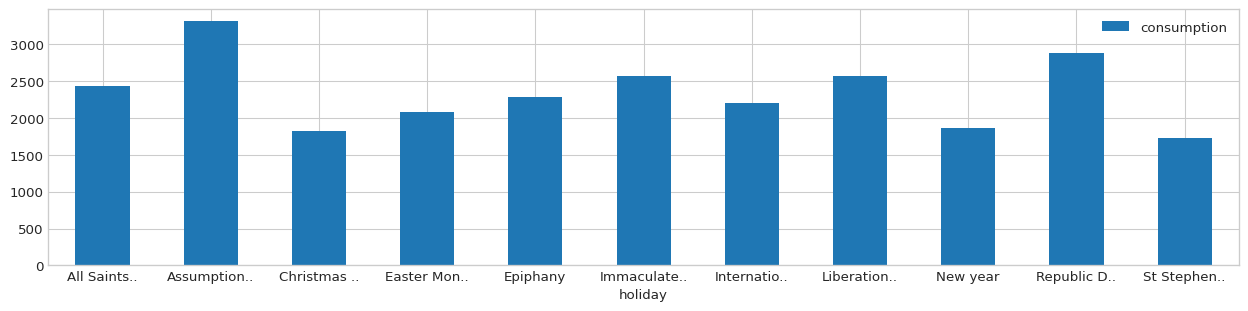

In [12]:
grouped_mean.index = grouped_mean.index.map(lambda x: (x[:10] + '..') if len(x) > 10 else x)
    
with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(16, 3.54), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))

    grouped_mean.plot.bar(ax=ax, rot=0)

One approach could be to group `holiday` values together according to the different levels of the target:

In [13]:
disc = KBinsDiscretizer(n_bins=2, encode='ordinal')
bins = disc.fit_transform(grouped_mean)
grouped_mean['bins'] = bins

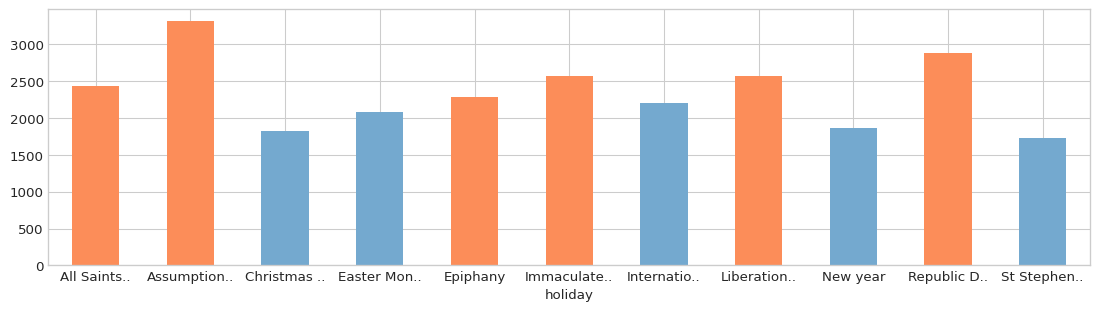

In [14]:
bin_values = [0, 1]
color_list = ['#74a9cf', '#fc8d59']
b2c = dict(zip(bin_values, color_list))

with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(14, 3.54), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))

    grouped_mean['consumption'].plot.bar(ax=ax, rot=0, 
                                         color=[b2c[i] for i in grouped_mean['bins']])

We can plot the distribution of the consumption values for each category: 

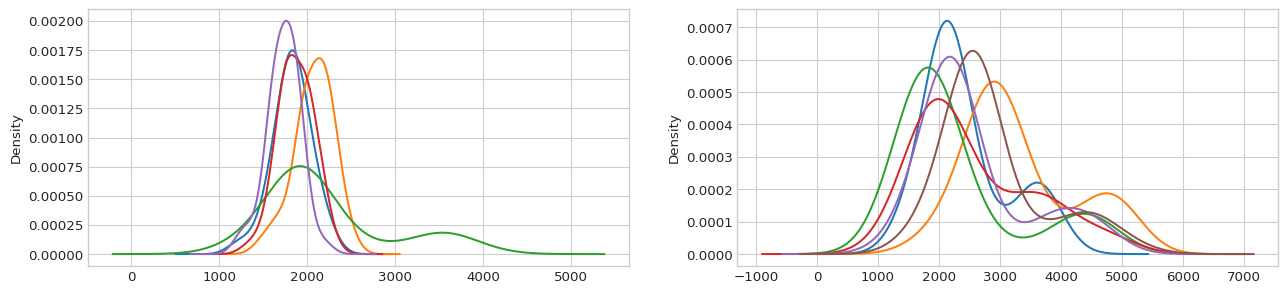

In [15]:
mapping = pd.Series(data=grouped_mean['bins'].values, index=original_idx).to_dict()
data['bins'] = data['holiday'].map(lambda x: mapping.get(x))

with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(16, 3.54), dpi=96)
    layout = (1, 2)
    ax0 = plt.subplot2grid(layout, (0, 0))
    ax1 = plt.subplot2grid(layout, (0, 1))

    subset = data[data['bins'] == 0]
    colors = get_colors('tab10', N=subset['holiday'].nunique())
    
    for i, (holiday, grouped) in enumerate(subset.groupby('holiday')):
        grouped['consumption'].plot.kde(ax=ax0, color=colors[i], bw_method=0.5)
        
    subset = data[data['bins'] == 1]
    colors = get_colors('tab10', N=subset['holiday'].nunique())
    
    for i, (holiday, grouped) in enumerate(subset.groupby('holiday')):
        grouped['consumption'].plot.kde(ax=ax1, color=colors[i], bw_method=0.5)

Going one step further, we could examine not only the mean of the target per `holiday` value but also other characteristics of its distribution. To take more aspects of the target's distribution into account, the `TargetClusterEncoder` clusters the different values of a categorical feature according to the mean, standard deviation, skewness and the [Wasserstein distance](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wasserstein_distance.html) between the distribution of the corresponding target's values and the distribution of all target's values (used as reference). 

In [16]:
enc = TargetClusterEncoder(
        feature='holiday', 
        max_n_categories=2, 
        excluded_categories='_novalue_'
)

X = data[['holiday']]
y = data['consumption']
enc = enc.fit(X, y)

We can update the `bins` column based on the encoder's mapping between values of `holiday` and clusters:

In [17]:
grouped_mean['bins'] = original_idx.map(lambda x: enc.mapping_[x])

... and plot the new features again:

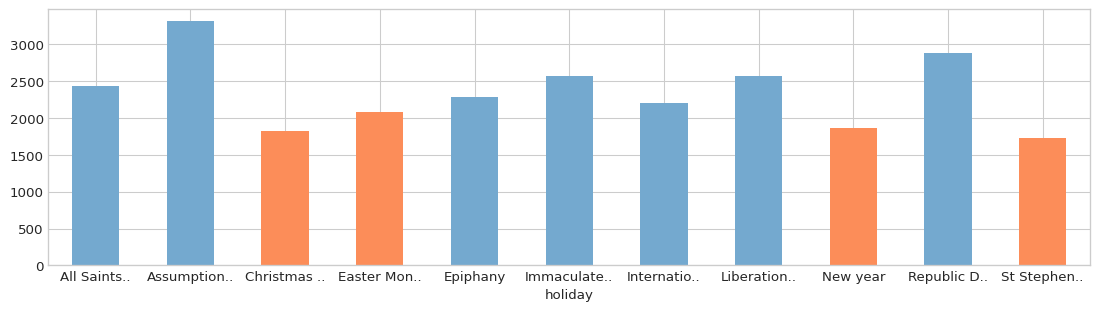

In [18]:
bin_values = [0, 1]
color_list = ['#74a9cf', '#fc8d59']
b2c = dict(zip(bin_values, color_list))

with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(14, 3.54), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))

    grouped_mean['consumption'].plot.bar(
        ax=ax, 
        rot=0, 
        color=[b2c[i] for i in grouped_mean['bins']]
    )

Again, we can plot the target distributions for each category to see what was achieved: 

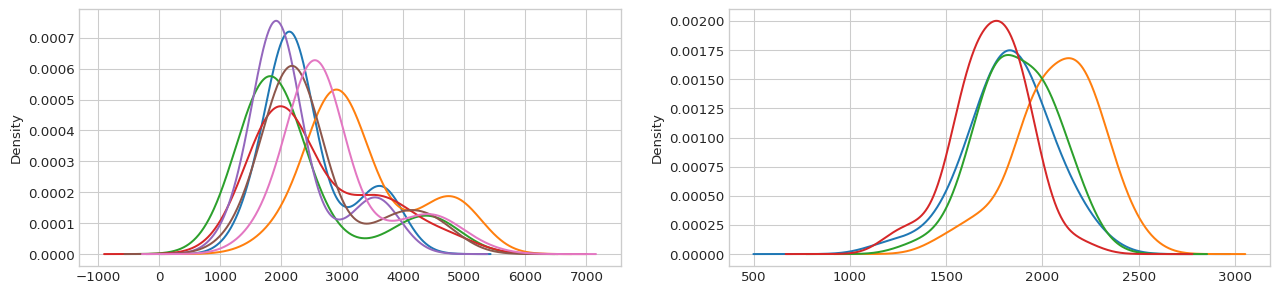

In [19]:
data['bins'] = data['holiday'].map(lambda x: enc.mapping_.get(x))

with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(16, 3.54), dpi=96)
    layout = (1, 2)
    ax0 = plt.subplot2grid(layout, (0, 0))
    ax1 = plt.subplot2grid(layout, (0, 1))

    subset = data[data['bins'] == 0]
    colors = get_colors('tab10', N=subset['holiday'].nunique())
    
    for i, (holiday, grouped) in enumerate(subset.groupby('holiday')):
        grouped['consumption'].plot.kde(ax=ax0, color=colors[i], bw_method=0.5)
        
    subset = data[data['bins'] == 1]
    colors = get_colors('tab10', N=subset['holiday'].nunique())
    
    for i, (holiday, grouped) in enumerate(subset.groupby('holiday')):
        grouped['consumption'].plot.kde(ax=ax1, color=colors[i], bw_method=0.5)

Not only the two clusters seem more homogeneous with respect to the distributions they include, but we also managed to distinguish the holidays according to their consumption profiles:   

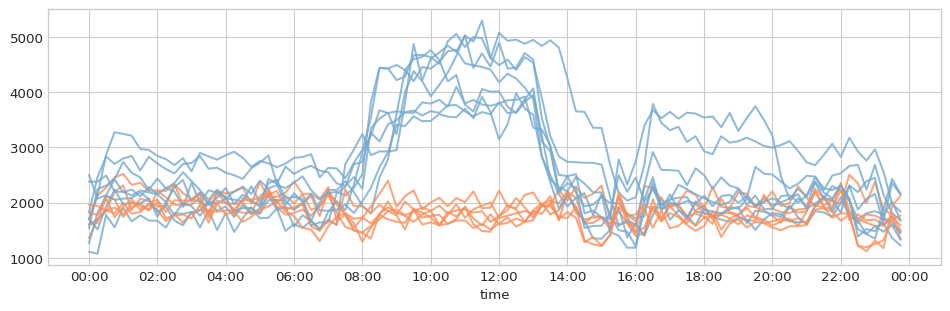

In [20]:
profiles = data.loc[
                data['holiday'] != '_novalue_', ['consumption', 'holiday', 'bins']
           ].copy()
profiles['date'] = profiles.index.date
profiles['time'] = profiles.index.time

with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 3.54), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))

    profiles.pivot(index='time', columns='date', values='consumption').plot(
        ax=ax, 
        alpha=0.8, 
        legend=None, 
        color=[b2c[i] for i in profiles['bins'].resample('D').first().dropna()]
    )
    ax.xaxis.set_major_locator(ticker.MultipleLocator(3600*2))

#### Conditional effect on target

One may be explicitly interested in clustering the `holiday` feature taking into account the hour-of-day feature: how similar are the target's values in two distinct values of `holiday` given similar values for the hour-of-day?

In this case, the encoder first stratifies the categorical feature `holiday` into groups with similar values of hour-of-day, and then examines the relationship between the categorical feature's values and the corresponding values of the target.

The stratification is carried out by a `sklearn.tree.DecisionTreeRegressor` model that first fits the `stratify_by` features (here hour-of-day) on the target values, and then uses the tree's leaf nodes as groups. Only the mean of the target's values per group is taken into account when deriving the clusters. 

The parameter `min_samples_leaf` defines the minimum number of samples required to be at a leaf node of the decision tree model. Note that the actual number that will be passed to the tree model is `min_samples_leaf` multiplied by the number of unique values in the categorical feature to transform.   

In [21]:
enc = TargetClusterEncoder(
        feature='holiday', 
        max_n_categories=2, 
        excluded_categories='_novalue_',
        stratify_by='hour',
        min_samples_leaf=5
)

In [22]:
data['hour'] = data.index.hour

X = data[['holiday', 'hour']]
y = data['consumption']
enc = enc.fit(X, y)

It is easy to understand the result of this operation if we consider that when the encoder groups holidays stratified by hours, it actually tries to group the daily profiles of the different holidays in the dataset. Since we already achieved this in the previous step, there shouldn't be any change in the way holidays are grouped:

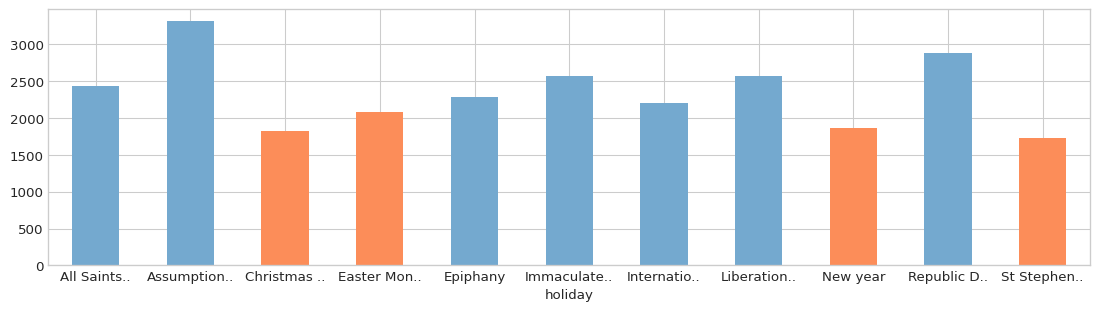

In [23]:
grouped_mean['bins'] = original_idx.map(lambda x: enc.mapping_[x])

with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(14, 3.54), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))

    grouped_mean['consumption'].plot.bar(
        ax=ax, 
        rot=0, 
        color=[b2c[i] for i in grouped_mean['bins']]
    )

## CategoricalEncoder

The `CategoricalEncoder` encodes a categorical feature by encaptulating all the aforementioned categorical encoders so far. If `max_n_categories` is not `None` and the number of unique values of the categorical feature is larger than the `max_n_categories` minus the `excluded_categories`, the `TargetClusterEncoder` will be called. 

If `encode_as = 'onehot'`, the result comes from a `TargetClusterEncoder` + `SafeOneHotEncoder` pipeline, otherwise from a `TargetClusterEncoder` + `SafeOrdinalEncoder` one:

```python
n_categories = X[self.feature].nunique()
use_target = (self.max_n_categories is not None) and (
    n_categories - len(self.excluded_categories_) > self.max_n_categories
)

if not use_target:
    self.feature_pipeline_ = Pipeline(
        [
            (
                "encode_features",
                SafeOneHotEncoder(
                    feature=self.feature, unknown_value=self.unknown_value
                ),
            )
            if self.encode_as == "onehot"
            else (
                "encode_features",
                SafeOrdinalEncoder(
                    feature=self.feature, unknown_value=self.unknown_value
                ),
            )
        ]
    )
else:
    self.feature_pipeline_ = Pipeline(
        [
            (
                "reduce_dimension",
                TargetClusterEncoder(
                    feature=self.feature,
                    stratify_by=self.stratify_by,
                    max_n_categories=self.max_n_categories,
                    excluded_categories=self.excluded_categories,
                    unknown_value=self.unknown_value,
                    min_samples_leaf=self.min_samples_leaf,
                    max_features=self.max_features,
                    random_state=self.random_state,
                ),
            ),
            (
                "to_pandas",
                FunctionTransformer(self._to_pandas),
            ),
            (
                "encode_features",
                SafeOneHotEncoder(
                    feature=self.feature, unknown_value=self.unknown_value
                ),
            )
            if self.encode_as == "onehot"
            else (
                "encode_features",
                SafeOrdinalEncoder(
                    feature=self.feature, unknown_value=self.unknown_value
                ),
            ),
        ]
    )
```

In [24]:
max_n_categories = data['holiday'].nunique() + 3

In [25]:
enc = CategoricalEncoder(feature='holiday', 
                         max_n_categories=max_n_categories, 
                         encode_as='onehot')

features = enc.fit_transform(X, y)
features[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [26]:
assert min(data['holiday'].nunique(), max_n_categories) == enc.n_features_out_

In [27]:
enc = CategoricalEncoder(feature='holiday', 
                         max_n_categories=max_n_categories, 
                         encode_as='ordinal')

features = enc.fit_transform(X, y)
features[:5]

array([[11],
       [11],
       [11],
       [11],
       [11]], dtype=int16)

In [28]:
assert min(data['holiday'].nunique(), max_n_categories) == np.unique(features).size

In [29]:
max_n_categories = data['holiday'].nunique() - 3

In [30]:
enc = CategoricalEncoder(feature='holiday', 
                         max_n_categories=max_n_categories, 
                         encode_as='onehot')

features = enc.fit_transform(X, y)
features[:5]

array([[0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [31]:
assert min(data['holiday'].nunique(), max_n_categories) == enc.n_features_out_

In [32]:
enc = CategoricalEncoder(feature='holiday', 
                         max_n_categories=max_n_categories, 
                         encode_as='ordinal')

features = enc.fit_transform(X, y)
features[:5]

array([[5],
       [5],
       [5],
       [5],
       [5]], dtype=int16)

In [33]:
assert min(data['holiday'].nunique(), max_n_categories) == np.unique(features).size

## An application of the categorical encoder

Suppose we want to use the demo data to predict the energy consumption of the building. The simplest model to use is a model that includes only the hour of the week as a feature. The hour of the week is a categorical feature and it can be encoded in one-hot form:

In [34]:
data['hourofweek'] = 24 * data.index.dayofweek + data.index.hour
dmatrix = CategoricalEncoder(feature='hourofweek', encode_as='onehot').fit_transform(data)

We can fit a linear model:

In [35]:
model = LinearRegression(fit_intercept=False).fit(dmatrix, y)

... and evaluate it in-sample:

In [36]:
pred = model.predict(dmatrix)

In [37]:
print(f"In-sample CV(RMSE) (%): {100*mean_squared_error(y, pred, squared=False)/y.mean()}")

In-sample CV(RMSE) (%): 19.332298975680697


The degrees of freedom of the model are:

In [38]:
np.linalg.matrix_rank(dmatrix)

168

We can ask the `CategoricalEncoder` to lump together the 168 hour-of-week values into only 60, and repeat the process:

In [39]:
X = data[['hourofweek']]
y = data['consumption']

dmatrix = CategoricalEncoder(
                feature='hourofweek', 
                encode_as='onehot',
                max_n_categories=60
          ).fit_transform(X, y)

model = LinearRegression(fit_intercept=False).fit(dmatrix, y)
pred = model.predict(dmatrix)

print(f"In-sample CV(RMSE) (%): {100*mean_squared_error(y, pred, squared=False)/y.mean()}")

In-sample CV(RMSE) (%): 19.349420155191982


This is practically the same performance with one third of the degrees of freedom:

In [40]:
np.linalg.matrix_rank(dmatrix)

60

------------------------